# Downloading Dataset ( Kaggle )


In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!curl https://file.io/Wd9iMHSMZ7DA --output final.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  531M    0  531M    0     0  27.7M      0 --:--:--  0:00:19 --:--:-- 33.7M


In [ ]:
!unzip final.zip

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as tv_utils
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch.utils.data as custom_data
from tqdm import tqdm

# Data preprocessing and utility

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_image(img, caption=None, save=False):
  image_array = img.numpy()
  plt.axis("off")

  if caption:
    plt.text(
        75,
        8,
        caption,
        style="italic",
        fontweight="bold",
        bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
    )

  plt.imshow(np.transpose(image_array, (1, 2, 0)))
  plt.show()


In [ ]:
import os
import pandas as pd
import torch
import torch.utils.data as data
from PIL import Image
import numpy as np

class PairedDataset(data.Dataset):
  def __init__(self, df_path=None, data_dir=None, transform=None, subset=None):
      self.df = pd.read_csv(df_path)
      if subset is not None:
          self.df = self.df[:subset]
      self.df.columns = ["image1", "image2", "label"]
      self.data_dir = data_dir
      self.transform = transform

  def __getitem__(self, index):
      pair1_path = os.path.join(self.data_dir, self.df.iat[index, 0])
      pair2_path = os.path.join(self.data_dir, self.df.iat[index, 1])

      pair1 = Image.open(pair1_path).convert("L")
      pair2 = Image.open(pair2_path).convert("L")

      if self.transform:
          pair1 = self.transform(pair1)
          pair2 = self.transform(pair2)

      label = torch.tensor([int(self.df.iat[index, 2])], dtype=torch.float32)

      return pair1, pair2, label

  def __len__(self):
      return len(self.df)

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor()
])

In [ ]:
df_train = "sign_data/train_data.csv"
df_test = "sign_data/test_data.csv"
dir_train = "sign_data/train/"
dir_test = "sign_data/test/"

In [ ]:
train_dataset = PairedDataset(
    df_train,
    dir_train,
    transform=transforms.Compose([
        transforms.Resize((105, 105)),
        transforms.ToTensor()
    ]),
    subset=None
)

evaluation_dataset = PairedDataset(
    df_test,
    dir_test,
    transform=transforms.Compose([
        transforms.Resize((105, 105)),
        transforms.ToTensor()
    ]),
    subset=None
)

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            self.create_conv_block(1, 96, 11, 1, False),
            self.create_conv_block(96, 256, 5, 2, True),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            self.create_conv_block(384, 256, 3, 1, True),
        )

        self.fc1 = nn.Sequential(
            self.create_linear_relu(30976, 1024),
            nn.Dropout2d(p=0.5),
            self.create_linear_relu(1024, 128),
            nn.Linear(128, 2)
        )

    def create_linear_relu(self, input_channels, output_channels):
        return nn.Sequential(nn.Linear(input_channels, output_channels),
        nn.ReLU(inplace=True))

    def create_conv_block(self, input_channels, output_channels, kernel_size,
    padding, dropout=True):
        if dropout:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size,
                stride=1, padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, stride=2),
                nn.Dropout2d(p=0.3)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size,
                stride=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, stride=2)
            )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        out1 = self.forward_once(input1)
        out2 = self.forward_once(input2)
        return out1, out2

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = (1 - label) * torch.pow(euclidean_distance, 2)
        loss_negative = label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        total_loss = torch.mean(loss_positive + loss_negative)
        return total_loss

In [ ]:
train_dataset

In [ ]:
train_loader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=128)
eval_loader = DataLoader(evaluation_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)

siamese_net = SiameseNetwork().cuda()
loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(siamese_net.parameters(), lr=1e-3, weight_decay=0.0005)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
siamese_net

SiameseNetwork(
  (cnn1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
    (2): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Sequential(
      (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Batc

In [ ]:
def train(train_loader, model=siamese_net, optimizer=optimizer, loss_function=loss_function):
  total_loss = 0.0
  num_batches = len(train_loader)

  model.train()

  for batch_idx, (pair_left, pair_right, label) in enumerate(tqdm(train_loader, total=num_batches)):
    pair_left, pair_right, label = pair_left.cuda(), pair_right.cuda(), label.cuda()

    optimizer.zero_grad()
    output1, output2 = model(pair_left, pair_right)

    contrastive_loss = loss_function(output1, output2, label)
    contrastive_loss.backward()
    optimizer.step()

    total_loss += contrastive_loss.item()

  mean_loss = total_loss / num_batches

  return mean_loss

In [ ]:
def evaluate(eval_loader):
  loss_list = []
  counter_list = []
  iteration_number = 0

  for i, data in tqdm(enumerate(eval_loader, 0), total=len(eval_loader)):
    pair_left, pair_right, label = data
    pair_left, pair_right, label = pair_left.cuda(), pair_right.cuda(), label.cuda()

    output1, output2 = siamese_net(pair_left, pair_right)
    contrastive_loss = loss_function(output1, output2, label)
    loss_list.append(contrastive_loss.item())

  loss_array = np.array(loss_list)
  mean_loss = loss_array.mean() / len(eval_loader)

  return mean_loss

In [ ]:
best_eval_loss = float('inf')

for epoch in tqdm(range(1, 8)):
  train_loss = train(train_loader)
  eval_loss = evaluate(eval_loader)

  print(f"Epoch: {epoch}")
  print(f"Training loss: {train_loss}")
  print(f"Evaluation loss: {eval_loss}")

  if eval_loss < best_eval_loss:
      best_eval_loss = eval_loss
      print(f"Best Evaluation loss: {best_eval_loss}")
      torch.save(siamese_net.state_dict(), "model.pth")
      print("Model Saved Successfully")

  0%|          | 0/182 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)

100%|██████████| 182/182 [02:26<00:00,  1.24it/s]

100%|██████████| 5747/5747 [01:08<00:00, 84.22it/s] 


Epoch: 1
Training loss: 1.181928284220643
Evaluation loss: 0.0002818704275288041
Best Evaluation loss: 0.0002818704275288041


 14%|█▍        | 1/7 [03:35<21:32, 215.43s/it]

Model Saved Successfully



100%|██████████| 182/182 [02:25<00:00,  1.25it/s]

 29%|██▊       | 2/7 [07:09<17:53, 214.73s/it]

Epoch: 2
Training loss: 1.1596943614902078
Evaluation loss: 0.0002820890101734048



100%|██████████| 182/182 [02:24<00:00,  1.26it/s]

100%|██████████| 5747/5747 [01:10<00:00, 80.98it/s]


Epoch: 3
Training loss: 1.161095081777363
Evaluation loss: 0.00028136186708992703
Best Evaluation loss: 0.00028136186708992703


 43%|████▎     | 3/7 [10:46<14:21, 215.48s/it]

Model Saved Successfully



100%|██████████| 182/182 [02:24<00:00,  1.26it/s]

 57%|█████▋    | 4/7 [14:25<10:50, 216.89s/it]

Epoch: 4
Training loss: 1.1588507392904261
Evaluation loss: 0.00028242733523116664



100%|██████████| 182/182 [02:25<00:00,  1.25it/s]

 71%|███████▏  | 5/7 [18:05<07:16, 218.30s/it]

Epoch: 5
Training loss: 1.156287548306224
Evaluation loss: 0.00028278981232056415



100%|██████████| 182/182 [02:26<00:00,  1.24it/s]

 86%|████████▌ | 6/7 [21:49<03:40, 220.02s/it]

Epoch: 6
Training loss: 1.1527212995749254
Evaluation loss: 0.0002818387864815366



100%|██████████| 182/182 [02:24<00:00,  1.26it/s]

100%|██████████| 7/7 [25:30<00:00, 218.60s/it]

Epoch: 7
Training loss: 1.1528855097162856
Evaluation loss: 0.0002828129561819144


In [ ]:
testpred = pd.read_csv(df_test)

In [ ]:
testpred.columns = ['image1', 'image2', 'label']

In [ ]:
testpred

,image1,image2,label
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1
...,...,...,...
5742,066/01_066.png,066/06_066.png,0
5743,066/01_066.png,066/08_066.png,0
5744,066/01_066.png,066/02_066.png,0
5745,066/01_066.png,066/05_066.png,0


tensor([[0.]])


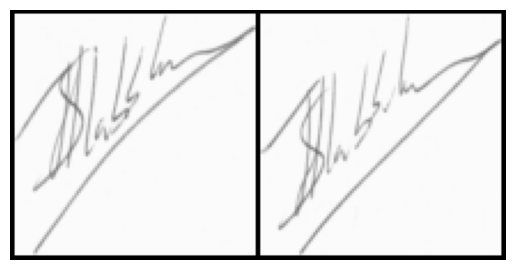

Predicted Euclidean Distance: 0.19876468181610107
Actual Label: Original Pair of Signature
tensor([[1.]])


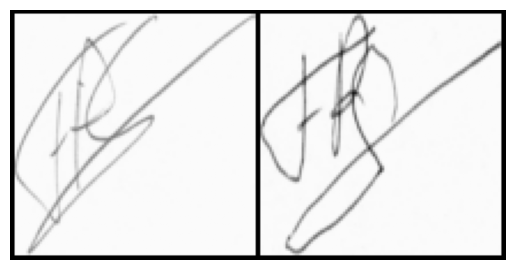

Predicted Euclidean Distance: 0.30117067694664
Actual Label: Forged Pair of Signature
tensor([[1.]])


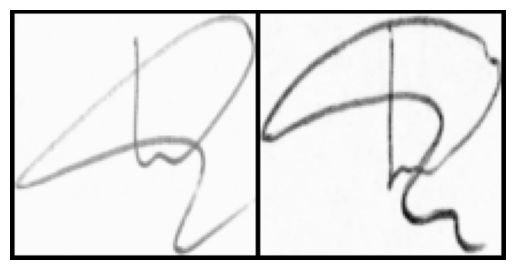

Predicted Euclidean Distance: 0.485198974609375
Actual Label: Forged Pair of Signature
tensor([[1.]])


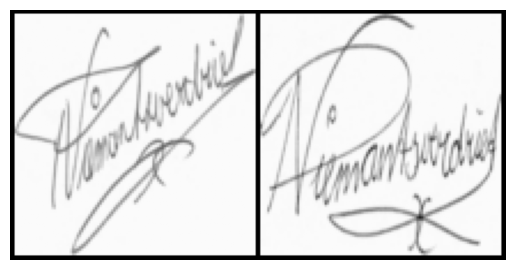

Predicted Euclidean Distance: 0.5105698704719543
Actual Label: Forged Pair of Signature
tensor([[1.]])


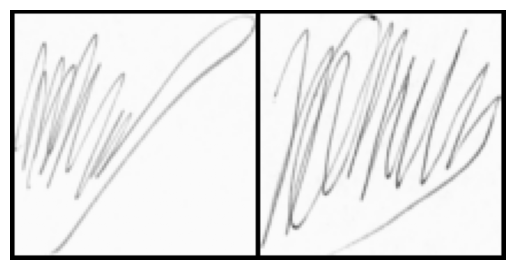

Predicted Euclidean Distance: 0.15974579751491547
Actual Label: Forged Pair of Signature
tensor([[1.]])


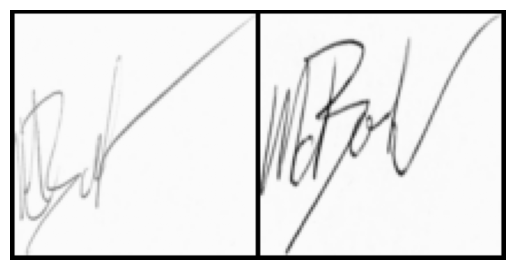

Predicted Euclidean Distance: 0.26062628626823425
Actual Label: Forged Pair of Signature
tensor([[1.]])


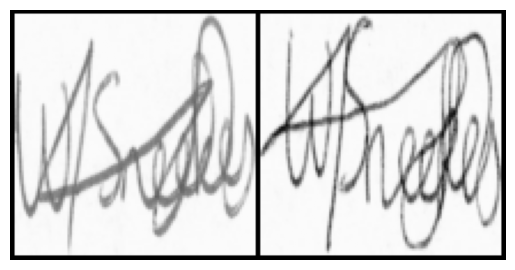

Predicted Euclidean Distance: 0.27191686630249023
Actual Label: Forged Pair of Signature
tensor([[0.]])


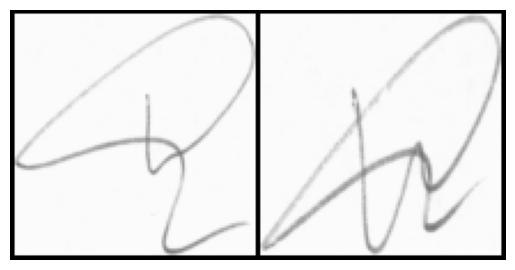

Predicted Euclidean Distance: 0.481812447309494
Actual Label: Original Pair of Signature
tensor([[0.]])


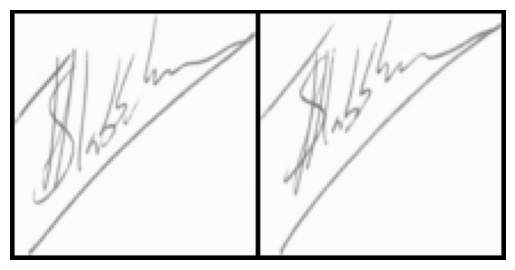

Predicted Euclidean Distance: 0.3844345808029175
Actual Label: Original Pair of Signature
tensor([[0.]])


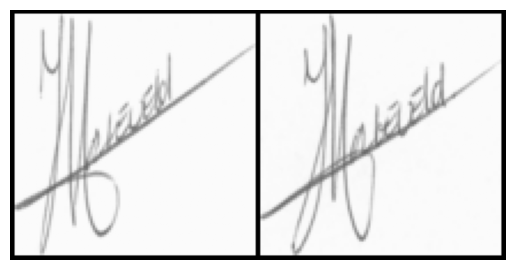

Predicted Euclidean Distance: 0.26068970561027527
Actual Label: Original Pair of Signature
tensor([[1.]])


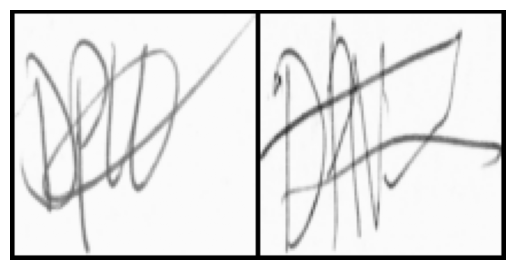

Predicted Euclidean Distance: 0.24249254167079926
Actual Label: Forged Pair of Signature


In [ ]:
for i, data in enumerate(eval_loader, 0):
  x0, x1, label = data
  concat_images = torch.cat((x0, x1), 0)
  out1, out2 = siamese_net(x0.to('cuda'), x1.to('cuda'))

  euclidean_distance = F.pairwise_distance(out1, out2)
  print(label)
  if label == torch.FloatTensor([[0]]):
    label_text = "Original Pair of Signature"
  else:
    label_text = "Forged Pair of Signature"

  display_image(tv_utils.make_grid(concat_images))
  print("Predicted Euclidean Distance:", euclidean_distance.item())
  print("Actual Label:", label_text)
  if i == 10:
    break